# Linear Regression using PyTorch

**[Faisal Z. Qureshi](http://vclab.science.uoit.ca)**  

- Dataset
- Our very own linear layer
- Our very own cost function

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

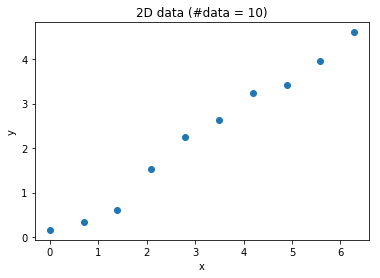

In [2]:
N = 10 # number of data points
m = .7
c = 0
x = np.linspace(0,2*np.pi,N)
y = m*x + c + np.random.normal(0,.3,x.shape)
plt.figure()
plt.plot(x,y,'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D data (#data = %d)' % N)
plt.show()

In [3]:
import torch

## Dataset

In [4]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample = {
            'feature': torch.tensor([1,self.x[idx]]), 
            'label': torch.tensor([self.y[idx]])}
        return sample

In [5]:
dataset = MyDataset(x, y)
for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['feature'], sample['label'])

0 tensor([1., 0.]) tensor([0.1616])
1 tensor([1.0000, 0.6981]) tensor([0.3410])
2 tensor([1.0000, 1.3963]) tensor([0.6164])
3 tensor([1.0000, 2.0944]) tensor([1.5236])
4 tensor([1.0000, 2.7925]) tensor([2.2541])
5 tensor([1.0000, 3.4907]) tensor([2.6375])
6 tensor([1.0000, 4.1888]) tensor([3.2471])
7 tensor([1.0000, 4.8869]) tensor([3.4276])
8 tensor([1.0000, 5.5851]) tensor([3.9587])
9 tensor([1.0000, 6.2832]) tensor([4.6055])


## Dataloader

In [6]:
from torch.utils.data import DataLoader

dataset = MyDataset(x, y)
batch_size = 4
shuffle = True
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [7]:
import pprint as pp
for i_batch, samples in enumerate(dataloader):
    print('\nbatch# = %s' % i_batch)
    print('samples: ')
    pp.pprint(samples)


batch# = 0
samples: 
{'feature': tensor([[1.0000, 2.7925],
        [1.0000, 1.3963],
        [1.0000, 0.6981],
        [1.0000, 5.5851]]),
 'label': tensor([[2.2541],
        [0.6164],
        [0.3410],
        [3.9587]])}

batch# = 1
samples: 
{'feature': tensor([[1.0000, 4.1888],
        [1.0000, 2.0944],
        [1.0000, 3.4907],
        [1.0000, 6.2832]]),
 'label': tensor([[3.2471],
        [1.5236],
        [2.6375],
        [4.6055]])}

batch# = 2
samples: 
{'feature': tensor([[1.0000, 4.8869],
        [1.0000, 0.0000]]),
 'label': tensor([[3.4276],
        [0.1616]])}


## Model

In [8]:
import torch.nn as nn
from torch.nn.parameter import Parameter
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        
        self.weight = Parameter(torch.Tensor(output_dim, input_dim))
        self.bias = Parameter(torch.Tensor(output_dim, 1))
        
        stdv = 1.
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)
        
    def forward(self, x):
        weight_and_bias = torch.cat((self.weight, self.bias), 1)
        #print(weight_and_bias)
        #print(weight_and_bias.t().shape)
        #print(x.shape)
        #print(self.weight.size())
        
        out = x.matmul(weight_and_bias.t())
        return out

### Setting a model for our problem

In [9]:
input_dim = 1
output_dim = 1

model = MyModel(input_dim, output_dim)

## Cost function

Often called loss or error

In [10]:
import torch.nn as nn
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        
    def forward(self, predictions, targets):
        print(predictions)
        print(targets)
        
        diff = torch.sub(predictions, targets)
        diff2 = torch.pow(diff, 2)
        err = torch.sum(diff2)
        return err

In [11]:
cost = MyLoss()

## Minimizing the cost function

In other words training (or learning from data)

In [12]:
num_epochs = 100  # How many times the entire training data is seen?
l_rate = 0.01
optimiser = torch.optim.SGD(model.parameters(), lr = l_rate) 

dataset = MyDataset(x, y)
batch_size = 4
shuffle = True
num_workers = 4
training_sample_generator = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

for epoch in range(num_epochs):
    if epoch % 10 == 0:
        print('Epoch = %s' % epoch)
    for batch_i, samples in enumerate(training_sample_generator):
        predictions = model(samples['feature'])
        error = cost(predictions, samples['label'])
        if epoch % 10 == 0:
            print('\tBatch = %s, Error = %s' % (batch_i, error.item()))
        
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimiser.zero_grad()
        
        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        error.backward()
        
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimiser.step()

Epoch = 0
tensor([[-0.2909],
        [-0.6254],
        [-0.0400],
        [-0.1236]], grad_fn=<MmBackward>)
tensor([[2.2541],
        [3.9587],
        [0.3410],
        [0.6164]])
	Batch = 0, Error = 28.183727264404297
tensor([[1.3823],
        [3.7296],
        [0.2086],
        [2.1647]], grad_fn=<MmBackward>)
tensor([[1.5236],
        [4.6055],
        [0.1616],
        [2.6375]])
	Batch = 1, Error = 1.0128040313720703
tensor([[3.2089],
        [3.7041]], grad_fn=<MmBackward>)
tensor([[3.2471],
        [3.4276]])
	Batch = 2, Error = 0.0779402107000351
tensor([[3.5829],
        [4.0615],
        [4.5401],
        [3.1043]], grad_fn=<MmBackward>)
tensor([[3.4276],
        [3.9587],
        [4.6055],
        [3.2471]])
tensor([[1.1798],
        [0.2317],
        [2.1280],
        [2.6021]], grad_fn=<MmBackward>)
tensor([[0.6164],
        [0.1616],
        [2.2541],
        [2.6375]])
tensor([[0.6920],
        [1.6314]], grad_fn=<MmBackward>)
tensor([[0.3410],
        [1.5236]])
tenso

## Lets see how well the model has learnt the data

In [13]:
#from torch.autograd.variable import Variable

x_for_plotting = np.linspace(0, 2*np.pi, 1000)
design_matrix = torch.tensor(np.vstack([np.ones(x_for_plotting.shape), x_for_plotting]).T, dtype=torch.float32)
#print('Design matrix:\n', design_matrix)
print('Design matrix shape:', design_matrix.shape)

y_for_plotting = model.forward(design_matrix)
print('y_for_plotting shape:', y_for_plotting.shape)

Design matrix shape: torch.Size([1000, 2])
y_for_plotting shape: torch.Size([1000, 1])


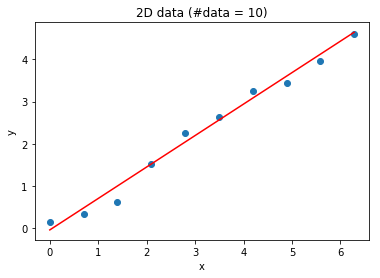

In [14]:
plt.figure()
plt.plot(x,y,'o')
plt.plot(x_for_plotting, y_for_plotting.data.numpy(), 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D data (#data = %d)' % N)
plt.show()